In [3]:
'''
Basic demonstration of the capabilities of the CRNN using TimeDistributed layers
Processes an MNIST image (or blank square) at each time step and sums the digits.
Learning is based on the sum of the digits, not explicit labels on each digit.
'''

from __future__ import print_function
import numpy as np

import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential
#from keras.initializations import norRemal, identity
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.optimizers import RMSprop, Adadelta
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.models import model_from_json
#import json

In [4]:
# for reproducibility
np.random.seed(2016)  
K.set_image_dim_ordering('tf')
#define some run parameters
batch_size      = 32
nb_epochs       = 1
examplesPer     = 60000
maxToAdd        = 8
hidden_units    = 200
size            = 28
#cutoff          = 1000

In [5]:
# the data, shuffled and split between train and test sets
(X_train_raw, y_train_temp), (X_test_raw, y_test_temp) = mnist.load_data()

#ignore "cutoff" section in full run
#X_train_raw     = X_train_raw[:cutoff]
#X_test_raw      = X_test_raw[:cutoff]
#y_train_temp    = y_train_temp[:cutoff]
#y_test_temp     = y_test_temp[:cutoff]

#basic image processing
X_train_raw = X_train_raw.astype('float32')
X_test_raw  = X_test_raw.astype('float32')
X_train_raw /= 255
X_test_raw  /= 255

10280960/11490434 [=========================>....] - ETA: 0s

In [6]:
print('X_train_raw shape:', X_train_raw.shape)
print(X_train_raw.shape[0], 'train samples')
print(X_test_raw.shape[0], 'test samples')
print("Building model")

X_train_raw shape: (60000, 28, 28)
60000 train samples
10000 test samples
Building model


In [10]:
#define our time-distributed setup
model = Sequential()
model.add(TimeDistributed(Convolution2D(8, 4, strides=4, padding='valid'), input_shape=(maxToAdd,size,size,1)))
model.add(Activation('relu'))
model.add(TimeDistributed(Convolution2D(16, 3, strides=4,padding ='valid')))
#model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),border_mode='valid')))
#model.add(Activation('relu'))
#model.add(TimeDistributed(Convolution2D(8, 3, 3, border_mode='valid')))
model.add(Activation('relu'))
#model.add(Reshape((maxToAdd,np.prod(model.output_shape[-3:])))) #this line updated to work with keras 1.0.2
model.add(TimeDistributed(Flatten()))
model.add(Activation('relu'))
model.add(GRU(return_sequences=True,output_dim=100))
model.add(GRU(return_sequences=False,output_dim=50))
model.add(Dropout(.2))
model.add(Dense(1))

rmsprop = RMSprop()
model.compile(loss='mean_squared_error', optimizer=rmsprop)

/storage/work/spd13/dl/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(return_sequences=True, units=100)`
  del sys.path[0]
/storage/work/spd13/dl/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(return_sequences=False, units=50)`
  


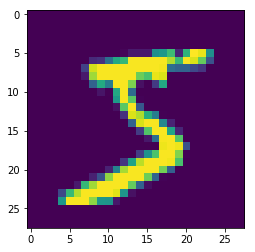

In [34]:
import matplotlib.pyplot as plt
plt.imshow(X_train_raw[0,:,:])
plt.show()

In [35]:
#run epochs of sampling data then training
for ep in range(0,nb_epochs):
    X_train       = []
    y_train       = []
    X_test        = []
    y_test        = []    
    
    X_train     = np.zeros((examplesPer,maxToAdd,size,size,1))

    for i in range(0,examplesPer):
        #initialize a training example of max_num_time_steps,im_size,im_size
        output      = np.zeros((maxToAdd,size,size,1))
        #decide how many MNIST images to put in that tensor
        numToAdd    = int(np.ceil(np.random.rand()*maxToAdd))
        #sample that many images
        indices     = np.random.choice(X_train_raw.shape[0],size=numToAdd)
        example     = X_train_raw[indices]
        #sum up the outputs for new output
        exampleY    = y_train_temp[indices]
        output[0:numToAdd,:,:,0] = example
        X_train[i,:,:,:,:] = output
        y_train.append(np.sum(exampleY))

    y_train     = np.array(y_train)
    
    if ep == 0:
        print("X_train shape: ",X_train.shape)
        print("y_train shape: ",y_train.shape)
    
    model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1,
              verbose=1)

X_train shape:  (60000, 8, 28, 28, 1)
y_train shape:  (60000,)


/storage/work/spd13/dl/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
60000/60000 [==============================] - 56s - loss: 50.0035    


In [36]:
#Test the model
X_test     = np.zeros((examplesPer,maxToAdd,size,size,1))
for i in range(0,examplesPer):
    output      = np.zeros((maxToAdd,size,size,1))
    numToAdd    = int(np.ceil(np.random.rand()*maxToAdd))
    indices     = np.random.choice(X_test_raw.shape[0],size=numToAdd)
    example     = X_test_raw[indices]
    exampleY    = y_test_temp[indices]
    output[0:numToAdd,:,:,0] = example
    X_test[i,:,:,:,:] = output
    y_test.append(np.sum(exampleY))

X_test  = np.array(X_test)
y_test  = np.array(y_test)       

preds   = model.predict(X_test)

#print the results of the test    
print(np.sum(np.sqrt(np.mean([ (y_test[i] - preds[i][0])**2 for i in range(0,len(preds)) ]))))
print("naive guess", np.sum(np.sqrt(np.mean([ (y_test[i] - np.mean(y_test))**2 for i in range(0,len(y_test)) ]))))

4.01529176342
naive guess 11.9130648692
